# Vision transformer with quantum self attention

### imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import h5py
from sklearn.model_selection import train_test_split

2022-09-18 09:15:44.634416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-18 09:15:44.634436: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.keras.backend.set_floatx('float64')

### data 

In [3]:
f = h5py.File("small_quark_gluon_candr","r")

In [4]:
x_train = f.get('X')
y_train = f.get('y')

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train[:], y_train[:], test_size=0.2, shuffle=True)

In [6]:
x_train = x_train.reshape(x_train.shape + (1,))
x_val = x_val.reshape(x_val.shape + (1,))

In [7]:
div1 = np.max(x_train, axis=(1,2)).reshape((x_train.shape[0],1,1,1))
div1[div1 == 0] = 1
x_train = x_train / div1

div1 = np.max(x_val, axis=(1,2)).reshape((x_val.shape[0],1,1,1))
div1[div1 == 0] = 1
x_val = x_val / div1

x_test = x_val

In [8]:
num_classes = 2
input_shape = (40, 40, 1)

### model

In [9]:
learning_rate = 0.00001
weight_decay = learning_rate * 10
batch_size = 32
num_epochs = 25
image_size = 40  # We'll resize input images to this size
patch_size = 3  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 12
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 3
#mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
mlp_head_units = [128, 64]

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
        #    height_factor=0.2, width_factor=0.2
        #),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2022-09-18 09:15:47.130393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-18 09:15:47.130413: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-18 09:15:47.130434: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-09-18 09:15:47.130634: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 40 X 40
Patch size: 3 X 3
Patches per image: 169
Elements per patch: 9


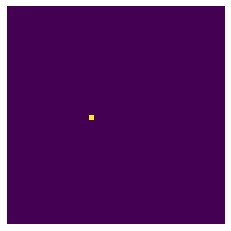

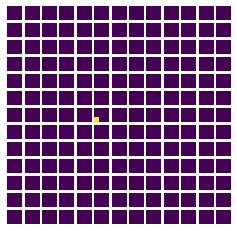

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [15]:
import pennylane as qml
from pennylane.transforms.batch_input import batch_input


Quantum self attention implementation

In [16]:
class QSAL(layers.Layer):
    def __init__(self, input_shape, output_dim, batch_size, device, layers, diff_method="best"):
        super(QSAL, self).__init__()

        self.in_shape = input_shape
        
        self.Uquery =  qml.QNode(self.U_circ, device, diff_method=diff_method)  
        self.Ukey =  qml.QNode(self.U_circ, device, diff_method=diff_method)  
        self.Uvalue =  qml.QNode(self.val_circ, device, diff_method=diff_method)  
        
        #self.Uquery = batch_input(self.Uquery, argnum=0)
        #self.Ukey = batch_input(self.Ukey, argnum=0)
        #self.Uvalue = batch_input(self.Uvalue, argnum=0)
        
        self.Uquery.interface = "tf"
        self.Ukey.interface = "tf"
        self.Uvalue.interface = "tf"
        
        self.Uquery_weights_size = (layers,input_shape[-1])
        self.Ukey_weights_size = (layers,input_shape[-1])
        self.Uvalue_weights_size = (layers,input_shape[-1])
        
        self.output_dim = output_dim
        
        super(QSAL, self).__init__(dynamic=True)
    
    def U_circ(self, inputs, weights):
        self.encoding(inputs)
        
        qml.BasicEntanglerLayers(weights=weights, wires=range(self.in_shape[-1]))
        
        return qml.expval(qml.PauliZ(0))
    
    def val_circ(self, inputs, weights):
        
        self.encoding(inputs)
        
        qml.BasicEntanglerLayers(weights=weights, wires=range(self.in_shape[-1]))
        
        return [qml.expval(qml.PauliZ(x)) for x in range(self.in_shape[-1])]
        
    def encoding(self, inputs):

        qml.AngleEmbedding(inputs, wires=range(self.in_shape[-1]))
        
        
    def build(self, input_shape):
        """Initializes the QNode weights.

        Args:
            input_shape (tuple or tf.TensorShape): shape of input data
        """
        
        
        self.Uquery_weights = self.add_weight(name="query", shape=self.Uquery_weights_size)
        self.Ukey_weights = self.add_weight(name="key", shape=self.Ukey_weights_size)
        self.Uvalue_weights = self.add_weight(name="value", shape=self.Uvalue_weights_size)       

        super().build(input_shape)
        
        
    def call(self, inputs):
        #Zqs = tf.convert_to_tensor([self.Uquery(i, self.Uquery_weights) for i in inputs])
        #Zks = tf.convert_to_tensor([self.Ukey(i, self.Ukey_weights) for i in inputs])
        #Ps = tf.convert_to_tensor([self.Uvalue(i, self.Uvalue_weights) for i in inputs])
        #Zqs = self.Uquery(inputs, self.Uquery_weights)
        #Zks = self.Ukey(inputs, self.Ukey_weights)
        #Ps = self.Uvalue(inputs, self.Uvalue_weights)
        outs = []
        for x in tf.unstack(inputs):
            Zqs = []
            Zks = []
            Ps = []
            for i in tf.unstack(x):
                Zqs.append(self.Uquery(i, self.Uquery_weights))
                Zks.append(self.Ukey(i, self.Ukey_weights))
                Ps.append(self.Uvalue(i, self.Uvalue_weights))
            Zqs = tf.stack(Zqs)
            Zks = tf.stack(Zks)
            Ps = tf.stack(Ps)
        #Zks = tf.map_fn(lambda i: self.Ukey(inputs[:,i,:]), tf.convert_to_tensor(range(inputs.shape[1])), dtype=tf.float32)
        #Ps = tf.map_fn(lambda i: self.Uvalue(inputs[:,i,:]), range(inputs.shape[1]), dtype=tf.float32)
            Zqs_expand = tf.expand_dims(Zqs, axis=-1)
            Zqs_expand = tf.repeat(Zqs_expand, repeats=Zqs_expand.shape[0], axis=1)
            Zks_expand = tf.expand_dims(Zks, axis=0)
            Zks_expand = tf.repeat(Zks_expand, repeats=Zks_expand.shape[1], axis=0)
            alphas = tf.math.exp(-tf.math.square(Zqs_expand - Zks_expand)) 
            alphas = alphas / tf.reduce_sum(alphas, axis=1)
            alpha_prod = tf.linalg.matmul(alphas, Ps)
            outs.append(alpha_prod)
            #outputs = tf.convert_to_tensor([i + alpha_prod[j] for i,j in enumerate(inputs)])
        outputs = tf.stack(outs)
        return outputs 
    
    def compute_output_shape(self, input_shape):
        return tf.TensorShape(self.output_dim)#.concatenate(self.output_dim)
    
    
    def __str__(self):
        detail = "<Quantum Keras Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__

    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Keras
        `Layer <https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer>`__. Set to
        ``"inputs"``."""
        return self._input_arg

    @staticmethod
    def set_input_argument(input_name = "inputs"):
        """
        Set the name of the input argument.

        Args:
            input_name (str): Name of the input argument
        """
        KerasLayer._input_arg = input_name

In [17]:
dev1 = qml.device('lightning.qubit', wires=projection_dim)

In [18]:
def create_vit_classifier(batch_size):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        #attention_output = layers.MultiHeadAttention(
            #num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        #)(x1, x1)
        attention_output = QSAL(x1.shape, x1.shape, batch_size, dev1, 2, diff_method="adjoint")(x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.4)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    # Classify outputs.
    #logits = layers.Dense(1, activation='sigmoid')(features)
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay, clipnorm=1.0
    )
    
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    
    model.compile(
        optimizer=opt,
        #
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        #loss = keras.losses.BinaryCrossentropy(),
        #metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            #keras.metrics.AUC()
            #keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    #model.build(input_shape=(40,40))
    #model.summary()

    #checkpoint_filepath = "/tmp/checkpoint"
    #checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #    checkpoint_filepath,
    #    monitor="val_accuracy",
    #    save_best_only=True,
    #    save_weights_only=True,
    #)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.001,
        callbacks=[es],
        shuffle=True,
        steps_per_epoch=10
        #callbacks=[checkpoint_callback],
    )

    #model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test[:100], y_val[:100])
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier(batch_size)
history = run_experiment(vit_classifier)

Epoch 1/25
10/10 [==============================] - 11691s 1159s/step - loss: 1.5936 - accuracy: 0.4562 - val_loss: 0.8283 - val_accuracy: 0.3839
Epoch 2/25
10/10 [==============================] - 57745s 5835s/step - loss: 1.4030 - accuracy: 0.4969 - val_loss: 0.8023 - val_accuracy: 0.5268
Epoch 3/25
10/10 [==============================] - 26672s 2328s/step - loss: 1.3179 - accuracy: 0.4688 - val_loss: 0.8566 - val_accuracy: 0.5089
Epoch 4/25
10/10 [==============================] - 13020s 1330s/step - loss: 1.1041 - accuracy: 0.5406 - val_loss: 0.9250 - val_accuracy: 0.5000
Epoch 5/25
 1/10 [==>...........................] - ETA: 3:26:09 - loss: 1.4399 - accuracy: 0.5000

In [ ]:
vit_classifier.summary()